# Team: PulseSeekers

## About the challenge:

Planetary seismology missions struggle with the power requirements necessary to send continuous seismic data back to Earth. But only a fraction of this data is scientifically useful! Instead of sending back all the data collected, what if we could program a lander to distinguish signals from noise, and send back only the data we care about? Your challenge is to write a computer program to analyze real data from the Apollo missions and the Mars InSight Lander to identify seismic quakes within the noise!


## Algorithm applied to a single test file:

[0.         0.02587891 0.05175781 0.07763672 0.10351562 0.12939453
 0.15527344 0.18115234 0.20703125 0.23291016 0.25878906 0.28466797
 0.31054688 0.33642578 0.36230469 0.38818359 0.4140625  0.43994141
 0.46582031 0.49169922 0.51757812 0.54345703 0.56933594 0.59521484
 0.62109375 0.64697266 0.67285156 0.69873047 0.72460938 0.75048828
 0.77636719 0.80224609 0.828125   0.85400391 0.87988281 0.90576172
 0.93164062 0.95751953 0.98339844 1.00927734 1.03515625 1.06103516
 1.08691406 1.11279297 1.13867188 1.16455078 1.19042969 1.21630859
 1.2421875  1.26806641 1.29394531 1.31982422 1.34570312 1.37158203
 1.39746094 1.42333984 1.44921875 1.47509766 1.50097656 1.52685547
 1.55273438 1.57861328 1.60449219 1.63037109 1.65625    1.68212891
 1.70800781 1.73388672 1.75976562 1.78564453 1.81152344 1.83740234
 1.86328125 1.88916016 1.91503906 1.94091797 1.96679688 1.99267578
 2.01855469 2.04443359 2.0703125  2.09619141 2.12207031 2.14794922
 2.17382812 2.19970703 2.22558594 2.25146484 2.27734375 2.3032

C:\Users\Vitiin\AppData\Local\Temp\ipykernel_15060\841063146.py:120: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


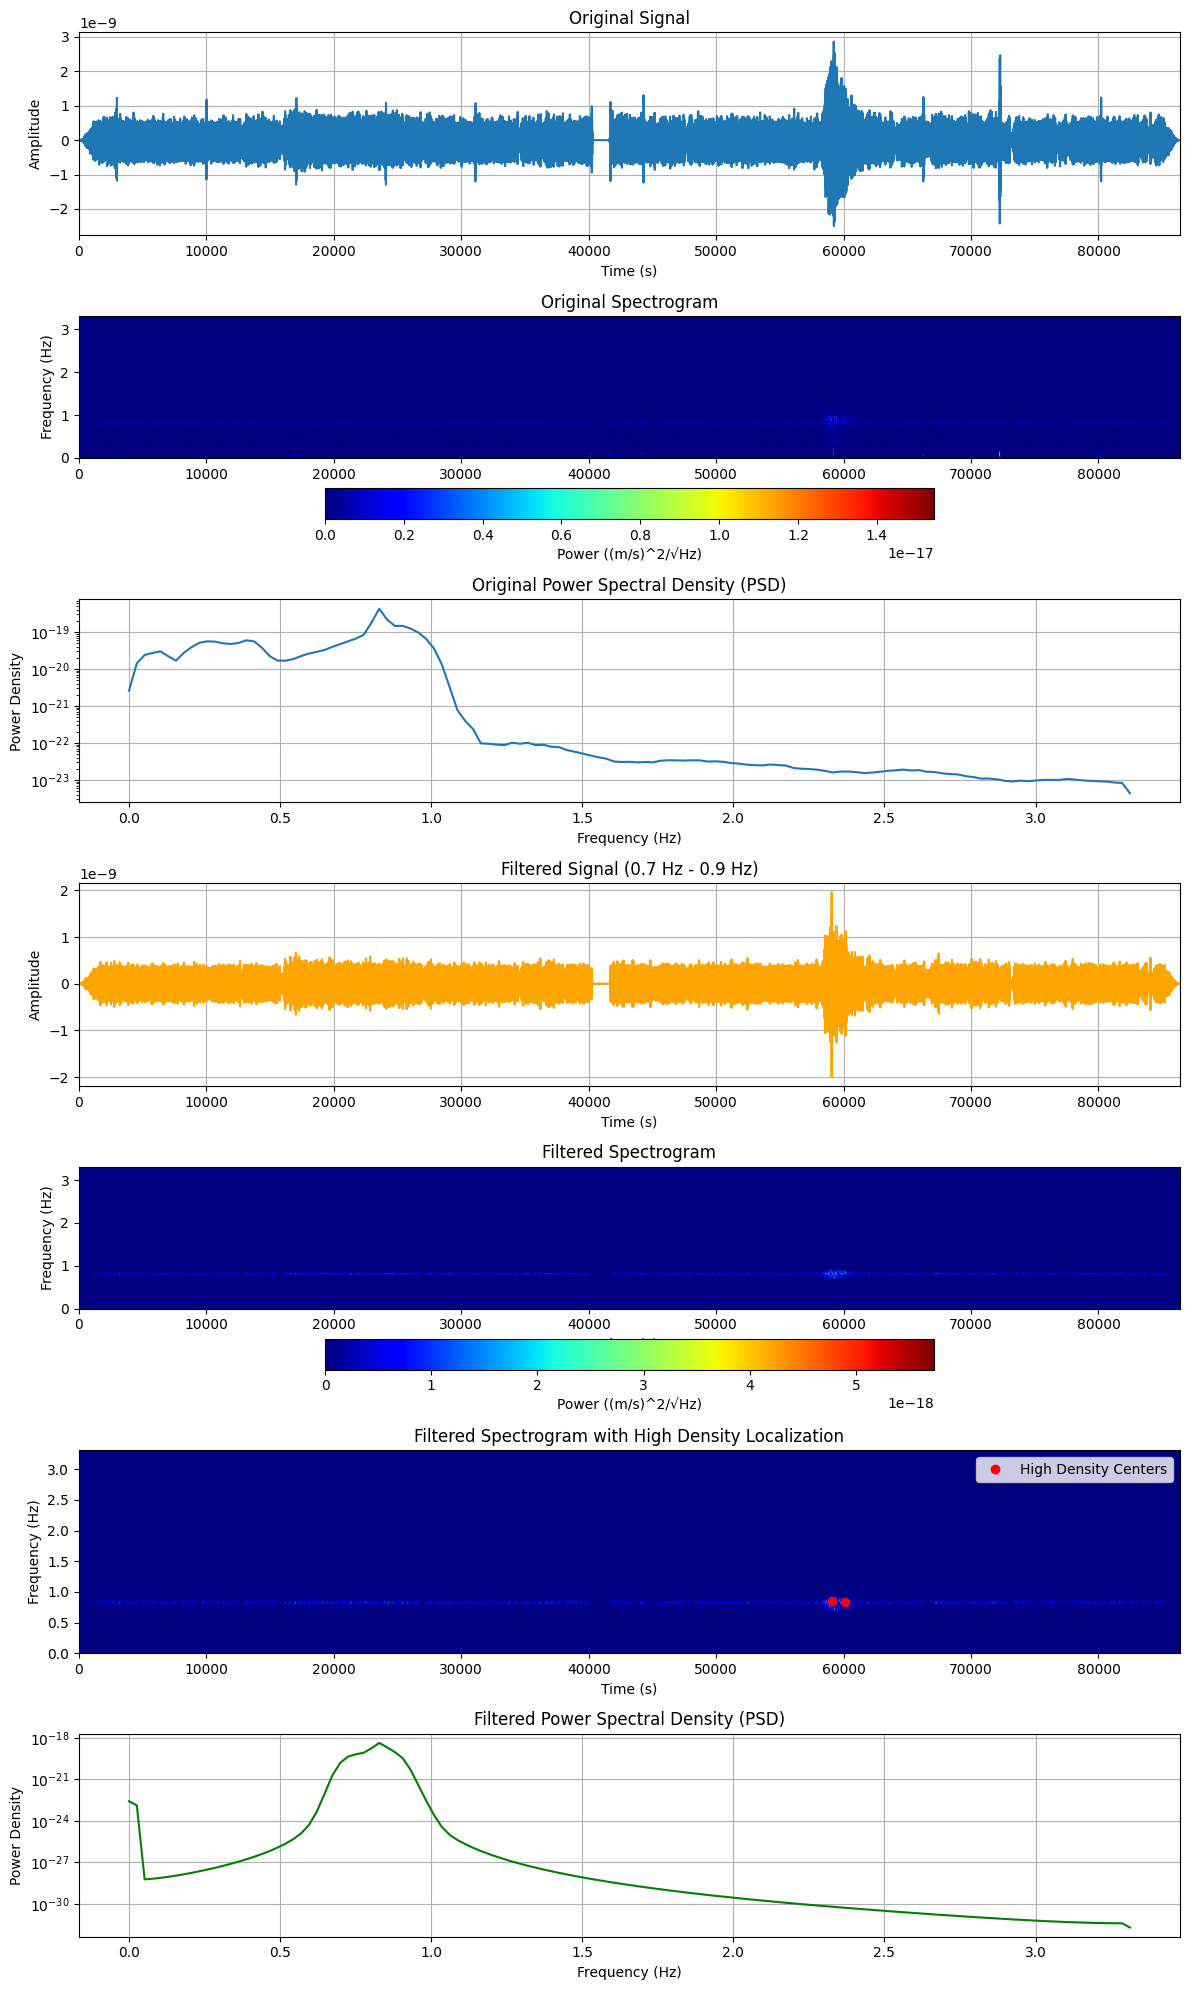

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, spectrogram
from obspy import read
from skimage.feature import peak_local_max
from matplotlib import cm

# Function to create and apply a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Path to the .mseed file
mseed_file = 'data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1977-04-24HR00_evid00923.mseed'

# Read the .mseed file
stream_data_from_sensor = read(mseed_file)
trace = stream_data_from_sensor.traces[0]
sampling_rate = trace.stats.sampling_rate
time = np.arange(0, len(trace.data)) / sampling_rate  # Create a relative time axis

# Bandpass filter parameters (0.5 Hz to 1.2 Hz)
lowcut = 0.7  # Lower cutoff frequency
highcut = 0.9  # Upper cutoff frequency

# Apply the bandpass filter to the signal
filtered_data = apply_bandpass_filter(trace.data, lowcut, highcut, sampling_rate)

# ----------------------- Calculation of Spectrogram and PSD -----------------------
# Spectrogram for the original signal
frequencies_orig, times_orig, sxx_orig = spectrogram(trace.data, fs=sampling_rate)

# Spectrogram for the filtered signal
frequencies_filt, times_filt, sxx_filt = spectrogram(filtered_data, fs=sampling_rate)

# Locate peaks in the filtered spectrogram using the peak_local_max function
peaks = peak_local_max(sxx_filt, min_distance=5, threshold_rel=0.6)  # Adjust the threshold for higher sensitivity

# PSD (Power Spectral Density) for the original signal
frequencies_psd_orig, psd_orig = welch(trace.data, fs=sampling_rate, nperseg=256)

# PSD (Power Spectral Density) for the filtered signal
frequencies_psd_filt, psd_filt = welch(filtered_data, fs=sampling_rate, nperseg=256)

# ----------------------- Plots -----------------------
fig, axs = plt.subplots(7, 1, figsize=(12, 20))

# Adjust the time limit for all plots
x_min, x_max = min(time), max(time)

# 1. Original Signal in time
axs[0].plot(time, trace.data, label='Original Signal')
axs[0].set_title('Original Signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)
axs[0].set_xlim(x_min, x_max)

# 2. Original Spectrogram
vals = axs[1].pcolormesh(times_orig, frequencies_orig, sxx_orig, cmap=cm.jet, shading='gouraud')
axs[1].set_title('Original Spectrogram')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlim(x_min, x_max)
cbar = plt.colorbar(vals, ax=axs[1], orientation='horizontal')
cbar.set_label('Power ((m/s)^2/√Hz)')

# 3. Original PSD
axs[2].semilogy(frequencies_psd_orig, psd_orig, label='Original PSD')
#print(frequencies_psd_orig)
axs[2].set_title('Original Power Spectral Density (PSD)')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Power Density')
axs[2].grid(True)

# 4. Filtered Signal in time
axs[3].plot(time, filtered_data, label='Filtered Signal', color='orange')
axs[3].set_title(f'Filtered Signal ({lowcut} Hz - {highcut} Hz)')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Amplitude')
axs[3].grid(True)
axs[3].set_xlim(x_min, x_max)

# 5. Filtered Spectrogram
vals_filt = axs[4].pcolormesh(times_filt, frequencies_filt, sxx_filt, cmap=cm.jet, shading='gouraud')
axs[4].set_title('Filtered Spectrogram')
axs[4].set_xlabel('Time (s)')
axs[4].set_ylabel('Frequency (Hz)')
axs[4].set_xlim(x_min, x_max)
cbar_filt = plt.colorbar(vals_filt, ax=axs[4], orientation='horizontal')
cbar_filt.set_label('Power ((m/s)^2/√Hz)')

# 6. Filtered Spectrogram with Peaks
axs[5].pcolormesh(times_filt, frequencies_filt, sxx_filt, cmap=cm.jet, shading='gouraud')
peak_times = times_filt[peaks[:, 1]]
peak_frequencies = frequencies_filt[peaks[:, 0]]
axs[5].plot(peak_times, peak_frequencies, 'ro', label='High Density Centers')
axs[5].set_title('Filtered Spectrogram with High Density Localization')
axs[5].set_xlabel('Time (s)')
axs[5].set_ylabel('Frequency (Hz)')
axs[5].set_xlim(x_min, x_max)
axs[5].legend()

# 7. Filtered PSD
axs[6].semilogy(frequencies_psd_filt, psd_filt, label='Filtered PSD', color='green')
axs[6].set_title('Filtered Power Spectral Density (PSD)')
axs[6].set_xlabel('Frequency (Hz)')
axs[6].set_ylabel('Power Density')
axs[6].grid(True)

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

## Iterate through all files and generate outputs

#### **Loading Ground Truth Data**

We read the actual event times from the Apollo 12 Grade A seismic event catalog.

#### **Data Preprocessing**

Seismic data from MiniSEED files are loaded and bandpass filtered to isolate frequencies between 0.7 Hz and 0.9 Hz.

#### **Spectral Analysis**

We compute spectrograms and power spectral densities (PSD) of the filtered signals to visualize their frequency content over time.

#### **Event Detection**

Peaks in the spectrograms are identified using local maxima detection to predict seismic event times.

#### **Performance Evaluation**

The predicted event times are compared against the ground truth using error metrics such as Mean Absolute Percentage Error (MAPE), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).

#### **Results Compilation**

The PSD data are saved for further analysis, and an output catalog containing the predictions is generated.


In [30]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
import pandas as pd
import os
import numpy as np
from scipy.signal import butter, filtfilt, welch, spectrogram
from obspy import read
from skimage.feature import peak_local_max
import pandas as pd


predicted_times = []
actual_times = []
mseed_directory = 'data/lunar/training/data/S12_GradeA'
lowcut = 0.7
highcut = 0.9


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def load_ground_truth():
    file_path = 'data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
    data = pd.read_csv(file_path)
    time_rel_values = data['time_rel(sec)'].tolist()
    return time_rel_values

def process_mseed_file(mseed_file, lowcut, highcut):
    predicted_times = []

    stream_data_from_sensor = read(mseed_file)
    trace = stream_data_from_sensor.traces[0]
    sampling_rate = trace.stats.sampling_rate
    time_abs = trace.stats.starttime

    filtered_data = apply_bandpass_filter(trace.data, lowcut, highcut, sampling_rate)

    _, times_filt, sxx_filt = spectrogram(filtered_data, fs=sampling_rate)

    frequencies_psd_orig, psd_orig = welch(trace.data, fs=sampling_rate, nperseg=256)

    peaks = peak_local_max(sxx_filt, min_distance=5, threshold_rel=0.6)
    
    peak_times = times_filt[peaks[:, 1]]
    
    predicted_times.append(round(peak_times[0], 1))

    return predicted_times, time_abs, frequencies_psd_orig, psd_orig


def process_all_mseed_files(mseed_directory, lowcut, highcut):
    catalog = [] 
    data_to_save = {} 
    predicted_times = []
    for filename in os.listdir(mseed_directory):
        if filename.endswith('.mseed'):
            mseed_file = os.path.join(mseed_directory, filename)
            predicted_times_list, time_abs, frequencies_psd_orig, psd_orig = process_mseed_file(mseed_file, lowcut, highcut)
            predicted_times.extend(predicted_times_list)

            # Create entries on the ouput catalog
            for predicted_time in predicted_times_list:
                catalog.append({
                    'filename': filename.replace('.mseed',''),
                    'time_abs(%Y-%m-%dT%H:%M:%S.%f)': time_abs,
                    'predicted_time': predicted_time
                })
            data_to_save[filename.replace('.mseed','')] = {}
            data_to_save[filename.replace('.mseed','')]['frequencies_psd_orig'] = frequencies_psd_orig
            data_to_save[filename.replace('.mseed','')]['psd_orig'] = psd_orig

            
    np.savez('original_psd_data.npz', **data_to_save)

    return predicted_times, catalog


actual_times = load_ground_truth()
predicted_times, catalog = process_all_mseed_files(mseed_directory, lowcut, highcut)

# Cálculo de MAE e RMSE
mape = mean_absolute_percentage_error(actual_times, predicted_times)
mae = mean_absolute_error(actual_times, predicted_times)
rmse = root_mean_squared_error(actual_times, predicted_times)

print(f"MAPE: {mape}")
print(f"MAE: {mae}")
print(f'RMSE: {rmse}')


# Converte o catálogo em um DataFrame pandas
df = pd.DataFrame(catalog)

# Salva o DataFrame como um arquivo CSV
df.to_csv('output_catalog.csv', index=False)

# Load data to show.
data = np.load('original_psd_data.npz', allow_pickle=True)
for d in data:
    print(data[d])




MAPE: 0.15446493543517753
MAE: 3725.189473684211
RMSE: 10479.589858198298
{'frequencies_psd_orig': array([0.        , 0.02587891, 0.05175781, 0.07763672, 0.10351562,
       0.12939453, 0.15527344, 0.18115234, 0.20703125, 0.23291016,
       0.25878906, 0.28466797, 0.31054688, 0.33642578, 0.36230469,
       0.38818359, 0.4140625 , 0.43994141, 0.46582031, 0.49169922,
       0.51757812, 0.54345703, 0.56933594, 0.59521484, 0.62109375,
       0.64697266, 0.67285156, 0.69873047, 0.72460938, 0.75048828,
       0.77636719, 0.80224609, 0.828125  , 0.85400391, 0.87988281,
       0.90576172, 0.93164062, 0.95751953, 0.98339844, 1.00927734,
       1.03515625, 1.06103516, 1.08691406, 1.11279297, 1.13867188,
       1.16455078, 1.19042969, 1.21630859, 1.2421875 , 1.26806641,
       1.29394531, 1.31982422, 1.34570312, 1.37158203, 1.39746094,
       1.42333984, 1.44921875, 1.47509766, 1.50097656, 1.52685547,
       1.55273438, 1.57861328, 1.60449219, 1.63037109, 1.65625   ,
       1.68212891, 1.70800781,